In [303]:
#All the libraries that we need

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold ,cross_val_score ,KFold ,train_test_split
from sklearn.metrics import accuracy_score , f1_score ,roc_auc_score ,confusion_matrix,roc_curve,auc ,plot_roc_curve

In [304]:
#Data Load - I used the basic titanic dataset
titanicData = pd.read_csv("titanic.csv")
print(titanicData.head)

<bound method NDFrame.head of       passenger_id  pclass  survived  \
0                1       1         1   
1                2       1         1   
2                3       1         0   
3                4       1         0   
4                5       1         0   
...            ...     ...       ...   
1304          1305       3         0   
1305          1306       3         0   
1306          1307       3         0   
1307          1308       3         0   
1308          1309       3         0   

                                                 name     sex      age  sibsp  \
0                       Allen, Miss. Elisabeth Walton  female  29.0000      0   
1                      Allison, Master. Hudson Trevor    male   0.9167      1   
2                        Allison, Miss. Helen Loraine  female   2.0000      1   
3                Allison, Mr. Hudson Joshua Creighton    male  30.0000      1   
4     Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000      1   
...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sex       1309 non-null   object
 1   pclass    1309 non-null   int64 
 2   embarked  1307 non-null   object
dtypes: int64(1), object(2)
memory usage: 30.8+ KB


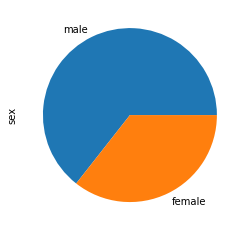

In [305]:
#Let's start with checking the data (It's look and structure within the focus on the categorical data)
titanicData[['sex','pclass','embarked']].info()
plt1=titanicData['sex'].value_counts().plot(kind='pie')


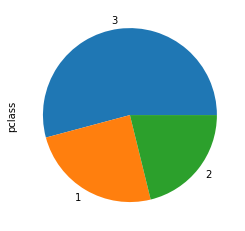

In [306]:
plt2=titanicData['pclass'].value_counts().plot(kind='pie')


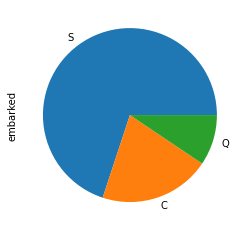

In [307]:
plt3=titanicData['embarked'].value_counts().plot(kind='pie')

In [308]:
# Function that controls the characteristics of the "survived" labeled data
target = 'survived'
def targetStructure(df , target):
    survived = df[target].sum()
    percent = round(survived/(len(df))*100,2)
    return print ("No of all records " + str(len(df)) + " survived: " + str(survived) + " percentage: " + str(percent) + "%")
targetStructure(titanicData , target)



No of all records 1309 survived: 500 percentage: 38.2%


In [309]:
# Now let's take a look on the missing data
def missingData(df):
    missing = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    output = pd.concat([missing , percent],axis=1 , keys= ['Missing' , 'Percent'])
    return output
print (missingData(titanicData))

Missing  Percent
cabin            1014    77.46
age               263    20.09
embarked            2     0.15
fare                1     0.08
ticket              0     0.00
parch               0     0.00
sibsp               0     0.00
sex                 0     0.00
name                0     0.00
survived            0     0.00
pclass              0     0.00
passenger_id        0     0.00


In [310]:
#Main model will be focused on the two variables  Age and Fare so let's take a look on them

titanicData[['age' , 'fare']].describe()

#First that comes to my mind is the lack of data in age variable (300 rows). We can also see the small standard deviation and that q2 lies near to the mean what means that data is much more consistent than the fare one that contains higer range between ist value what means huge diversity between values. Fare data is also differs far more from the normal distribution so I'll try to standarize this data befor creating model 


,age,fare
count,1046.000000,1308.000000
mean,29.881135,33.295479
std,14.413500,51.758668
min,0.166700,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,512.329200


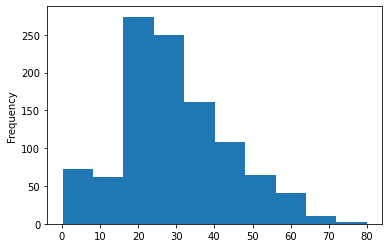

In [311]:

titanicData['age'].plot(kind="hist")


In [312]:
titanicData["fare"] = titanicData["fare"].fillna(titanicData["fare"].mean(),inplace=False)
titanicData["fare_log"] = np.log(titanicData["fare"])
titanicData["fare_log"].describe()
##Its about 17 rows so we can fill them with log mean. Because of it we get more normal distribution
titanicData["fare_log"]=titanicData["fare_log"].replace([np.inf, -np.inf], np.nan)
titanicData= titanicData.drop("fare", axis = 1)
titanicData["fare_log"].describe()
# titanicData["fare"].describe()
#titanicData["fare_log"].plot(kind="hist")


count    1292.000000
mean        2.949348
std         0.953011
min         1.153984
25%         2.070022
50%         2.674149
75%         3.446410
max         6.238967
Name: fare_log, dtype: float64

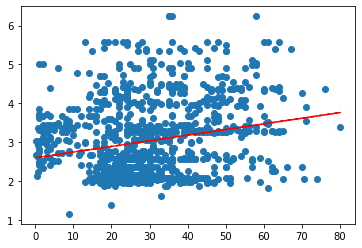

age  fare_log
age       1.000000  0.215606
fare_log  0.215606  1.000000


In [313]:
#To create scatter plot I removed missing data and in next function changed its structure
scatterData = titanicData[['age', 'fare_log']].dropna(inplace=False)
x = scatterData['age']
y = scatterData['fare_log']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

print(scatterData.corr(method="pearson"))
# From pearson correlation we can see that correlation coefficent is quite small (0.21) so data isn't strongly correlated

In [314]:
#Then  I removed data that is specific for each passenger because it doesn't affect their survival and created a split between trai and test set

unwanted = ["name" , 'cabin' , 'passenger_id' , 'ticket']
titanicData.drop(unwanted , axis =1 , inplace = True)
train , test = train_test_split(titanicData, test_size=0.3 , random_state = 17)
print ("Train set" )
targetStructure(train , target)
print ("Test set")
targetStructure(test , target)


Train set
No of all records 916 survived: 350 percentage: 38.21%
Test set
No of all records 393 survived: 150 percentage: 38.17%


In [315]:
#some of the data modification that is needed to create models (dummy tables from categorical data and filling age into two groups : within the mean or the median of survived and non-survived based on the group in wich you are in)

def modifyData(df):

    df["embarked"].fillna("S", inplace = True) 
    df["fare_log"] = pd.to_numeric(df["fare_log"])
    one_hot = pd.get_dummies(df, columns=['sex','embarked','pclass'])

    meandf= one_hot
    grouped = one_hot
    meandf['age'] = one_hot["age"].fillna(one_hot["age"].mean(), inplace = False)
    median = one_hot.groupby(['survived'])['age'].median()
    grouped = grouped.set_index(['survived'])
    grouped['age'] = grouped['age'].fillna(median)
    grouped = grouped.reset_index()
    meandf.dropna(inplace=True)
    grouped.dropna(inplace=True)
    return meandf , grouped
meandf_train ,grouped_train = modifyData(train)

print (meandf_train.info())
print (grouped_train.info())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 442 to 623
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    905 non-null    int64  
 1   age         905 non-null    float64
 2   sibsp       905 non-null    int64  
 3   parch       905 non-null    int64  
 4   fare_log    905 non-null    float64
 5   sex_female  905 non-null    uint8  
 6   sex_male    905 non-null    uint8  
 7   embarked_C  905 non-null    uint8  
 8   embarked_Q  905 non-null    uint8  
 9   embarked_S  905 non-null    uint8  
 10  pclass_1    905 non-null    uint8  
 11  pclass_2    905 non-null    uint8  
 12  pclass_3    905 non-null    uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 49.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 915
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    905 non-

In [316]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 442 to 623
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    916 non-null    int64  
 1   survived  916 non-null    int64  
 2   sex       916 non-null    object 
 3   age       723 non-null    float64
 4   sibsp     916 non-null    int64  
 5   parch     916 non-null    int64  
 6   embarked  916 non-null    object 
 7   fare_log  905 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 64.4+ KB


In [317]:
titanicData["fare_log"].describe()

count    1292.000000
mean        2.949348
std         0.953011
min         1.153984
25%         2.070022
50%         2.674149
75%         3.446410
max         6.238967
Name: fare_log, dtype: float64

In [318]:
meandf_test ,grouped_test = modifyData(test)
print (meandf_test.info())
print (grouped_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 1021 to 932
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    387 non-null    int64  
 1   age         387 non-null    float64
 2   sibsp       387 non-null    int64  
 3   parch       387 non-null    int64  
 4   fare_log    387 non-null    float64
 5   sex_female  387 non-null    uint8  
 6   sex_male    387 non-null    uint8  
 7   embarked_C  387 non-null    uint8  
 8   embarked_Q  387 non-null    uint8  
 9   embarked_S  387 non-null    uint8  
 10  pclass_1    387 non-null    uint8  
 11  pclass_2    387 non-null    uint8  
 12  pclass_3    387 non-null    uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 21.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 392
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    387 non

In [319]:

def giveXandY(df): 
    X = df.drop(['survived'] , axis = 1 , inplace = False ) 
    return  X  ,df['survived'] 
X ,Y = giveXandY(meandf_train)
print (X.info())
print (X.describe())
#Creation of logical Regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(X, Y)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 442 to 623
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         905 non-null    float64
 1   sibsp       905 non-null    int64  
 2   parch       905 non-null    int64  
 3   fare_log    905 non-null    float64
 4   sex_female  905 non-null    uint8  
 5   sex_male    905 non-null    uint8  
 6   embarked_C  905 non-null    uint8  
 7   embarked_Q  905 non-null    uint8  
 8   embarked_S  905 non-null    uint8  
 9   pclass_1    905 non-null    uint8  
 10  pclass_2    905 non-null    uint8  
 11  pclass_3    905 non-null    uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 42.4 KB
None
              age       sibsp       parch    fare_log  sex_female    sex_male  \
count  905.000000  905.000000  905.000000  905.000000  905.000000  905.000000   
mean    29.785069    0.500552    0.382320    2.946288    0.354696    0.645304   
std     12

LogisticRegression()

In [320]:
def  drawRoc (df):
    i=10
    tprs = []
    aucs = []
    fig, ax = plt.subplots()
    mean_fpr = np.linspace(0, 1, 100)
    viz = plot_roc_curve(df, X, Y,
                            name='ROC fold {}'.format(1),
                            alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

Fit time: 0.04
F1 socre: 72.24%
AUCROC: 84.60%
Accuracy: 79.34%
Sensivity: 70.03%


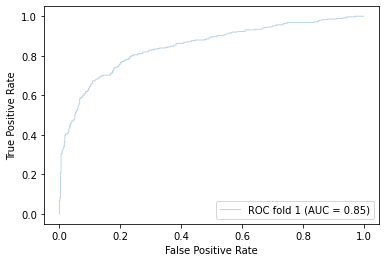

In [321]:
#Model Validation
score = {'F1':'f1', 'AUCROC':'roc_auc','Accuracy':'accuracy','Precision': 'precision', 'Recall': 'recall'}

kfold = model_selection.KFold(n_splits=10, random_state=100)
results_kfold = model_selection.cross_validate(logisticRegr,X, Y,scoring=score, cv=kfold)
print("Fit time: %.2f" % (results_kfold['fit_time'].mean())) 
print("F1 socre: %.2f%%" % (results_kfold['test_F1'].mean()*100.0)) 
print("AUCROC: %.2f%%" % (results_kfold['test_AUCROC'].mean()*100.0)) 
print("Accuracy: %.2f%%" % (results_kfold['test_Accuracy'].mean()*100.0)) 
print("Sensivity: %.2f%%" % (results_kfold['test_Recall'].mean()*100.0)) 
drawRoc(logisticRegr)




In [322]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(X, Y)



RandomForestClassifier()

Fit time: 0.27 
F1 socre: 69.30%
AUCROC: 82.60%
Accuracy: 77.12%
Sensivity: 67.85%


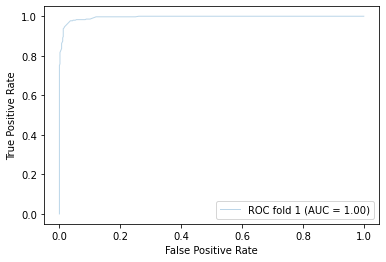

In [323]:
#Random forest validation
results_kfold = model_selection.cross_validate(rf,X, Y,scoring=score, cv=kfold)
print("Fit time: %.2f " % (results_kfold['fit_time'].mean())) 
print("F1 socre: %.2f%%" % (results_kfold['test_F1'].mean()*100.0)) 
print("AUCROC: %.2f%%" % (results_kfold['test_AUCROC'].mean()*100.0)) 
print("Accuracy: %.2f%%" % (results_kfold['test_Accuracy'].mean()*100.0)) 
print("Sensivity: %.2f%%" % (results_kfold['test_Recall'].mean()*100.0)) 
drawRoc(rf)


Confusion Matrix : 
 [[200  38]
 [ 46 103]]
Sensitivity (TP/(TP+FN)): 84.03% 
Specificity (TN/FN+TN) :  69.13% 
Accuracy :78.30% 
F1 : 71.03% 
AUCROC : 77.17% 


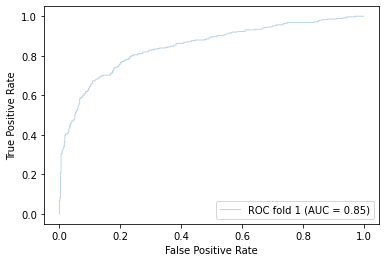

In [324]:
#Comparison between Logistioc regression and Random Forest
##LOGISTIC REGRESSION
X_test , Y_test = giveXandY(meandf_test)
prediction = logisticRegr.predict(X_test)

cm = confusion_matrix(Y_test,prediction)
print('Confusion Matrix : \n', cm)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print("Sensitivity (TP/(TP+FN)): %.2f%% " % round (sensitivity*100 ,3))

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print("Specificity (TN/FN+TN) :  %.2f%% " % round(specificity*100,3))


print ("Accuracy :%.2f%% " % round(accuracy_score(prediction,Y_test)*100,3))
print ("F1 : %.2f%% " % round(f1_score(prediction,Y_test)*
100,3))
print ("AUCROC : %.2f%% " % round(roc_auc_score(prediction,Y_test)*100,3))


drawRoc(logisticRegr)


Confusion Matrix : 
 [[208  30]
 [ 48 101]]
Sensitivity (TP/(TP+FN)): 87.39% 
Specificity (TN/FN+TN) :  67.78% 
Accuracy :79.84% 
F1 : 72.14% 
AUCROC : 79.17% 


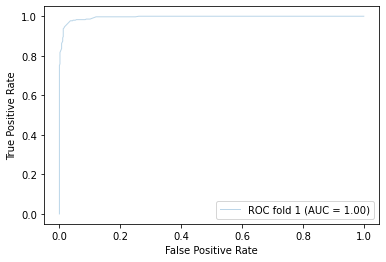

In [325]:
##Random Forest
prediction = rf.predict(X_test)

cm = confusion_matrix(Y_test,prediction)
print('Confusion Matrix : \n', cm)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print("Sensitivity (TP/(TP+FN)): %.2f%% " % round (sensitivity*100 ,3))

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print("Specificity (TN/FN+TN) :  %.2f%% " % round(specificity*100,3))
\

print ("Accuracy :%.2f%% " % round(accuracy_score(prediction,Y_test)*100,3))
print ("F1 : %.2f%% " % round(f1_score(prediction,Y_test)*
100,3))
print ("AUCROC : %.2f%% " % round(roc_auc_score(prediction,Y_test)*100,3))

drawRoc(rf)